## Toy MC plots for the paper
----------
Generates those plots that are used in the final version of the paper. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ultrasurfaces_paper_plotstyle.mplstyle")

from toy_mc import generator
from importlib import reload

In [2]:
delta_msq_31 = 2.515e-3
sinsq_theta_23 = 0.565
# convert this to sin**2(2 \theta)
theta_23 = np.arcsin(np.sqrt(sinsq_theta_23))
sinsq_2theta_23 = np.sin(2 * theta_23)**2
default_pars = generator.OscPars(delta_msq_31, sinsq_2theta_23)

default_response = generator.Response(1., 0.08)

bin_edges = np.logspace(1., 2., 26)

In [3]:
gen = generator.Generator(int(1e5), default_response, default_pars)
h0 = gen.get_histogram(bin_edges)
h0_true = gen.get_histogram(bin_edges, variable="true_energy")

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


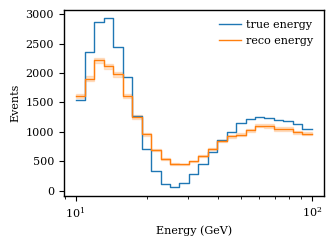

In [7]:
from toy_mc.histogram import plot_histogram

plt.style.use("ultrasurfaces_paper_plotstyle.mplstyle")

fig, ax = plt.subplots()
plot_histogram(h0_true, ax=ax, show_errorband=False, label="true energy")
plot_histogram(h0, ax=ax, label="reco energy")
plt.semilogx()
plt.legend()
plt.xlabel("Energy (GeV)")
plt.ylabel("Events")
plt.tight_layout()
plt.savefig("plot_output/toy_mc_histogram_true_reco.pdf")
plt.show()

In [16]:
# Generate several sets at different values of mu
reload(generator)
gen_nominal = generator.Generator(
    int(1e5), default_response, default_pars, name="nominal", rng_seed=0
)
# It looks like there is a breakdown point where, if the response is *too* different,
# the whole thing doesn't work anymore.
gen_sys_1 = generator.Generator(
    int(1e5),
    generator.Response(1.05 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_01",
    rng_seed=0
)
gen_sys_2 = generator.Generator(
    int(1e5),
    generator.Response(0.95 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_02",
    rng_seed=0
)
gen_sys_3 = generator.Generator(
    int(1e5),
    generator.Response(0.975 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_03",
    rng_seed=0
)
gen_sys_4 = generator.Generator(
    int(1e5),
    generator.Response(1.025 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_04",
    rng_seed=0
)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.
Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.
Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.
Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.
Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


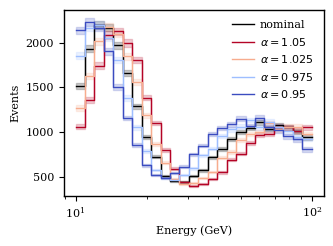

In [17]:
from toy_mc.histogram import plot_histogram

plt.style.use("ultrasurfaces_paper_plotstyle.mplstyle")

fig, ax = plt.subplots()
# write alpha instead of mu in the legend because we write that in the paper
plot_histogram(gen_nominal.get_histogram(bin_edges), ax=ax, label="nominal", color="k")
# color each histogram with a colormap according to its alpha value
cmap = plt.get_cmap("coolwarm")

plot_histogram(gen_sys_1.get_histogram(bin_edges), ax=ax, label=r"$\alpha=1.05$", color=cmap(1.0))
plot_histogram(gen_sys_4.get_histogram(bin_edges), ax=ax, label=r"$\alpha=1.025$", color=cmap(0.7))
plot_histogram(gen_sys_3.get_histogram(bin_edges), ax=ax, label=r"$\alpha=0.975$", color=cmap(0.3))
plot_histogram(gen_sys_2.get_histogram(bin_edges), ax=ax, label=r"$\alpha=0.95$", color=cmap(0.0))
plt.semilogx()
plt.legend()
plt.xlabel("Energy (GeV)")
plt.ylabel("Events")
plt.tight_layout()
plt.savefig("plot_output/toy_mc_histogram_systematics.pdf")
plt.show()